In [1]:
import numpy as np
import torch
import torchvision
import cv2 as cv
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms.autoaugment import AutoAugmentPolicy, AutoAugment

from torchsampler.imbalanced import ImbalancedDatasetSampler
from matplotlib import pyplot

In [2]:

train_dir = './train_images'
test_dir = './test_images'

transform = transforms.Compose(
    [transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Grayscale(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

# 20% of the train dataset will be used as a validation exercise
valid_size = 0.2
batch_size = 32

num_train = len(train_data)
# (0, 1, 2, 3, ..., num_train)
indices_train = list(range(num_train))
# Reorders the indexes randomly (so we get 7, 4, 19...)
np.random.shuffle(indices_train)

# The first valid_size% of indexes will be for validation purposes
split_tv = int(np.floor(valid_size * num_train))

# Get the indexes, split between training and validation
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

train_sampler = ImbalancedDatasetSampler(train_data,train_new_idx)
valid_sampler = ImbalancedDatasetSampler(train_data,valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
classes = ('noface','face')

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 18, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(18, 32, 5)
        self.fc1 = nn.Linear(32* 6 * 6, 48)
        self.fc2 = nn.Linear(48, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

network = Net()
network.train()
network.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr = 0.001, momentum=0.9)

In [40]:
epoch = 1
max_epoch = 5
print_every_n_batch = 400

best_network: Net = network
best_loss_validation = 999999999
steps_since_last_best = 0
threshold_early_stopping = 4 # Stop after 4 iterations without a new best network
best_model_found = False

# Save the values as we train for plotting
training_loss_values = []
validation_loss_values = []
epoch_values = []

while not best_model_found and epoch <= max_epoch:

    total_loss_training = 0.0
    i = 0
    
    for data_training, target_training in train_loader:

        optimizer.zero_grad()
        inputs, labels = data_training.to(device), target_training.to(device)

        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss_training += loss.item()

        #Every 400 batches, we test the model on the validation data
        if i % print_every_n_batch == print_every_n_batch - 1:    # print every n mini-batches
            running_loss_training = total_loss_training / print_every_n_batch
            total_loss_training = 0.0
            total_loss_validation = 0.0


            # We feed the validation data to the network
            for data_valid, labels_valid in valid_loader:
                images, labels = data_valid.to(device), labels_valid.to(device)
                outputs = network(images)
                loss = criterion(outputs,labels)
                total_loss_validation += loss.item()
            
            running_loss_validation = total_loss_validation / len(valid_loader)

            print(epoch, i+1, "-", "Training loss: ", running_loss_training, " - Validation loss:", running_loss_validation)
            validation_loss_values.append(running_loss_validation)
            training_loss_values.append(running_loss_training)
            epoch_values.append(epoch + i/len(train_loader))

            if(running_loss_validation < best_loss_validation):
                best_loss_validation = running_loss_validation
                best_network = network
                steps_since_last_best = 0
            else:
                steps_since_last_best += 1

            if steps_since_last_best >= threshold_early_stopping:
                best_model_found = True
                break

        i += 1

    epoch += 1

network = best_network

1 400 - Training loss:  0.055875842323875984  - Validation loss: 0.06728718963372383
1 800 - Training loss:  0.05576582728477661  - Validation loss: 0.053373941522231974
1 1200 - Training loss:  0.05462658166827168  - Validation loss: 0.055425014320167935
1 1600 - Training loss:  0.05390745930140838  - Validation loss: 0.05483710951535258
1 2000 - Training loss:  0.04906127435649978  - Validation loss: 0.04505401191675633
2 400 - Training loss:  0.05225397589369095  - Validation loss: 0.04927854479930627
2 800 - Training loss:  0.052691546106361786  - Validation loss: 0.04910098677375337
2 1200 - Training loss:  0.04989307488925988  - Validation loss: 0.043250009099318476
2 1600 - Training loss:  0.05478529603773495  - Validation loss: 0.06911570874962775
2 2000 - Training loss:  0.04271277585241478  - Validation loss: 0.046251806998398245
3 400 - Training loss:  0.04494143094256287  - Validation loss: 0.045137327543572595
3 800 - Training loss:  0.04510690082839574  - Validation loss:

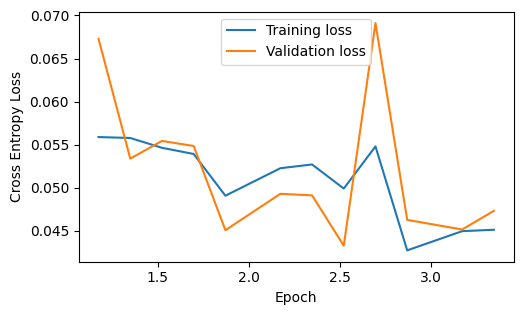

In [41]:
# Plot the values:
pyplot.rcParams["figure.figsize"] = (1,2.5)
loss_figure = pyplot.figure()
loss_figure = loss_figure.add_axes([0,0,max(epoch_values)+1,1])
loss_figure.plot(epoch_values, training_loss_values, label="Training loss")
loss_figure.plot(epoch_values, validation_loss_values, label="Validation loss")
loss_figure.set_xlabel("Epoch")
loss_figure.set_ylabel("Cross Entropy Loss")
loss_figure.legend()


In [42]:
# Saving the model
torch.save(network.state_dict(), "./face_recognizer_after_retrain.pt")

In [5]:
# Loading the model
network = Net()
network.load_state_dict(torch.load("./face_recognizer_after_retrain.pt"))
network.to(device)

Net(
  (conv1): Conv2d(1, 18, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(18, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)

In [43]:
correct = 0
total = 0
with torch.no_grad():
    for imgs, labls in test_loader:
        images, labels = imgs.to(device), labls.to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %2.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96.05 %


In [7]:
original_image = cv.imread('./corpo.png')

# Create the sub-images of the original image with the sliding window
window_size_x = 36
window_size_y = 36
face_radius = window_size_x
total_scaling = 1

transform = transforms.Compose(
    [ transforms.Grayscale(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0,),std=(1,))])


to_detect = original_image 

network.to(device)

while(to_detect.shape[0] > window_size_y and to_detect.shape[1] > window_size_x) :
    for y_window in range(0, to_detect.shape[0],window_size_y):
        for x_window in range(0, to_detect.shape[1], window_size_x):
            # Extract image:
            sub_image = to_detect[
                y_window:y_window+window_size_y,
                x_window:x_window+window_size_x,
            ]
            sub_image_PIL = Image.fromarray(sub_image)
            sub_image_PIL = sub_image_PIL.resize((36,36))
            sub_image_PIL = transform(sub_image_PIL)

            input = sub_image_PIL.to(device)
            outputs = network(input)
            predicted = torch.softmax(outputs.data, 1)
            face_probability = predicted[0][1].item()

            if(face_probability > 0.90):
                x_back_to_scale = int(x_window/total_scaling)
                y_back_to_scale = int(y_window+18/total_scaling)
                radius_scaled = int(face_radius/total_scaling)
                cv.rectangle(
                    original_image, 
                    (x_back_to_scale, y_back_to_scale),
                    (x_back_to_scale+radius_scaled, y_back_to_scale+radius_scaled),
                    (0, 255, 0),
                    2
                )

            x_window += 1
        
        y_window += 1
     
    step_scaling = 0.95   # percent of original size
    total_scaling = total_scaling*step_scaling
    width = int(to_detect.shape[1] * step_scaling)
    height = int(to_detect.shape[0] * step_scaling)
    dim = (width, height)

    to_detect = cv.resize(to_detect, dim, interpolation = cv.INTER_AREA)

cv.imshow("img",original_image)
cv.waitKey(0)

-1

We see that our recognizer finds the faces, but also a lot of non faces.
We therefore give the image of our hikers in the forest without their faces, and use the mini patches as pre-labelled dataset to retrain the model (as we know they will not have a face)

In [44]:
# Create the new sub-images
import os

# Load the images of the folder
texture_directory = 'texture_images'
texture_images = [] 
# iterate over files in
# that directory
for filename in os.listdir(texture_directory):
    f = os.path.join(texture_directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        texture_images.append(cv.imread(f))

# Create the sub-images of the original image with the sliding window
window_size_x = 36
window_size_y = 36
face_radius = window_size_x
total_scaling = 1

transform = transforms.Compose(
    [ transforms.Grayscale(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0,),std=(1,))])


step_scaling = 0.90
face_probability_thresh = 0.1
image_number = 1
sub_images_created = 0

for to_detect in texture_images:
    print("Image number "+str(image_number)+" - Subimages created: "+str(sub_images_created))
    while(to_detect.shape[0] > window_size_y and to_detect.shape[1] > window_size_x) :
        for y_window in range(0, to_detect.shape[0],window_size_y):
            for x_window in range(0, to_detect.shape[1], window_size_x):
                # Extract image:
                sub_image = to_detect[
                    y_window:y_window+window_size_y,
                    x_window:x_window+window_size_x,
                ]

                sub_image = cv.resize(sub_image, (36, 36))
                sub_image_PIL = Image.fromarray(sub_image)
                sub_image_PIL = sub_image_PIL.resize((36,36))
                sub_image_PIL = transform(sub_image_PIL)

                input = sub_image_PIL.to(device)
                outputs = network(input)
                predicted = torch.softmax(outputs.data, 1)
                face_probability = predicted[0][1].item()

                if(face_probability > face_probability_thresh):
                    sub_image_name = "./new_subimages/" + str(image_number) + "-" + str(x_window) + "-" + str(y_window) + "x" + str(total_scaling) + ".pgm"
                    sub_image = cv.cvtColor(sub_image, cv.COLOR_BGR2GRAY)
                    cv.imwrite(sub_image_name, sub_image)
                    sub_images_created += 1
        
                x_window += 1
            y_window += 1
        
        total_scaling = total_scaling*step_scaling
        width = int(to_detect.shape[1] * step_scaling)
        height = int(to_detect.shape[0] * step_scaling)
        dim = (width, height)
        to_detect = cv.resize(to_detect, dim, interpolation = cv.INTER_AREA)
    
    image_number += 1

Image number 1 - Subimages created: 0
Image number 2 - Subimages created: 27
Image number 3 - Subimages created: 46
Image number 4 - Subimages created: 408
Image number 5 - Subimages created: 408
Image number 6 - Subimages created: 408
Image number 7 - Subimages created: 414
Image number 8 - Subimages created: 475
Image number 9 - Subimages created: 635
Image number 10 - Subimages created: 2150
Image number 11 - Subimages created: 2289
Image number 12 - Subimages created: 2376
Image number 13 - Subimages created: 2582
Image number 14 - Subimages created: 2696
Image number 15 - Subimages created: 2696
Image number 16 - Subimages created: 10525
Image number 17 - Subimages created: 10559
Image number 18 - Subimages created: 11066
Image number 19 - Subimages created: 11170
Image number 20 - Subimages created: 11649
Image number 21 - Subimages created: 11675
Image number 22 - Subimages created: 11703
Image number 23 - Subimages created: 11811
Image number 24 - Subimages created: 12038
Image